train a model to predict what the single dice classes are

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.models import Sequential, Model
from keras.preprocessing import image as image_k


In [54]:
from tensorflow.keras.layers import BatchNormalization


# Set parameters
img_width, img_height = 30, 30

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
    MaxPooling2D((2, 2)),
    #Dropout(0.5),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    #Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # Assuming 3 classes
])

# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
#     MaxPooling2D((2, 2)),
#     BatchNormalization(),  # Add BatchNormalization for improved stability
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     BatchNormalization(),
#     Dropout(0.25),  # Adjust dropout rate as needed
#     Conv2D(128, (3, 3), activation='relu'),
#     Conv2D(128, (3, 3), activation='relu'),  # Add another convolutional layer for more feature extraction
#     MaxPooling2D((2, 2)),
#     BatchNormalization(),
#     Dropout(0.5),
#     Flatten(),
#     Dense(1024, activation='relu'),  # Increase hidden layer size for more complex patterns
#     Dropout(0.5),
#     Dense(6, activation='softmax')  # Assuming 6 classes (modify for your dataset)
# ])


# model = Sequential([
#     Conv2D(16, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
#     MaxPooling2D((2, 2)),
#     Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l1(0.01)),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(6, activation='softmax')  # Assuming 3 classes
# ])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
activation_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers[1:]])  # Exclude the input layer



def preprocess_image(image_path):
    img = image_k.load_img(image_path, target_size=(img_width, img_height), color_mode = "grayscale")

    x = image_k.img_to_array(img)
    x=x/255.
    x = np.expand_dims(x, axis=0)
    return x


def plot_activation_maps(activation_maps):
    num_maps = activation_maps.shape[2]
    num_cols = 8  # Assuming 8 columns for visualization, adjust as needed
    num_rows = num_maps // num_cols + (1 if num_maps % num_cols != 0 else 0)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))

    for i in range(num_maps):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(activation_maps[:,:,i], cmap='viridis')
        ax.axis('off')
        #ax.set_title(f'Map {i+1}')
    
    # Hide any empty subplots
    for i in range(num_maps, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


Found 1982 images belonging to 6 classes.
Found 217 images belonging to 6 classes.


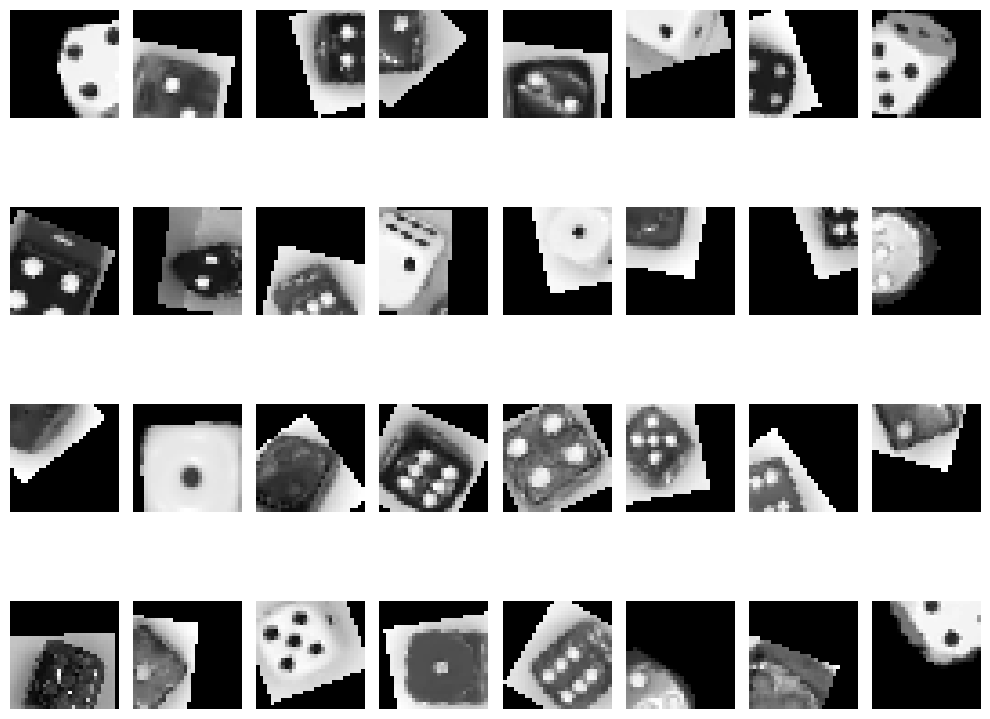

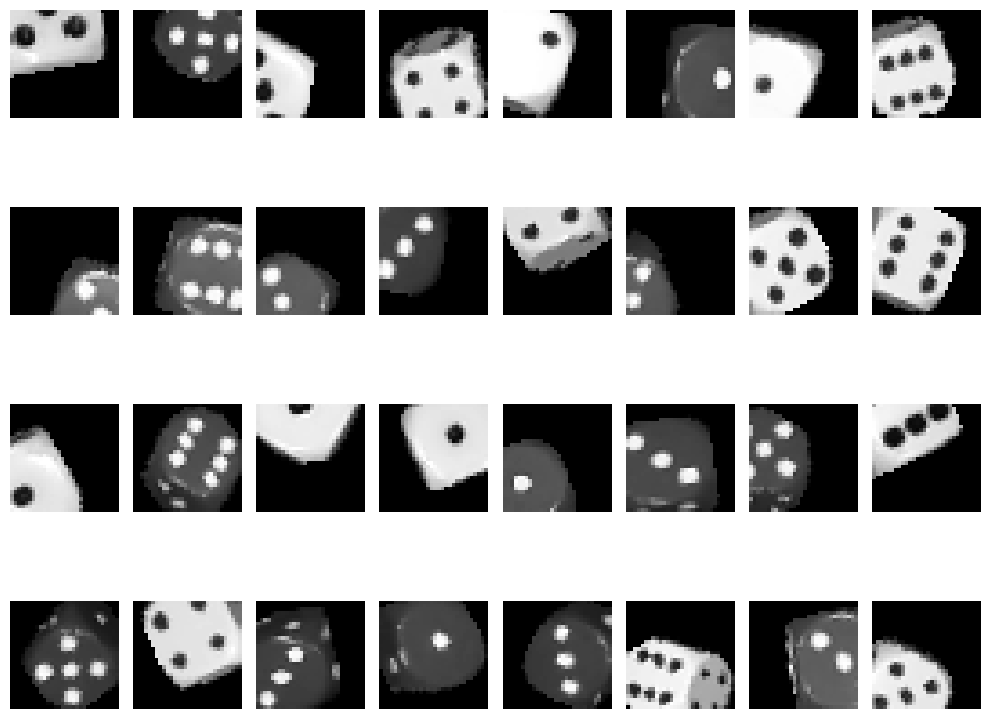

In [55]:
batch_size = 32

# Data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1, 
    horizontal_flip=True,  # Enable horizontal flip
    rotation_range=180,
    shear_range=0.2,
    width_shift_range=15,
    height_shift_range=15,
    #zoom_range=0.05,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)

train_generator = train_datagen.flow_from_directory(
    '/home/bule/projects/Dice/workspace/data/new_filz/combined_Trainset',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Specify grayscale images
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    '/home/bule/projects/Dice/workspace/data/new_filz/combined_Trainset',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Specify grayscale images
    subset='validation'
)


# Display one batch of training images
train_images, train_labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(batch_size):
    plt.subplot(4, 8, i+1)
    plt.imshow(train_images[i].reshape(img_width, img_height), cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()

# Display one batch of validation images
val_images, val_labels = next(validation_generator)
plt.figure(figsize=(10, 10))
for i in range(batch_size):
    plt.subplot(4, 8, i+1)
    plt.imshow(val_images[i].reshape(img_width, img_height), cmap='gray')
    plt.axis('off')
    plt.tight_layout()

plt.show()


In [62]:

# Train the model
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=100 # Adjust the number of epochs according to your needs
)

Epoch 1/100


61/61 [==============================] - 1s 10ms/step - loss: 0.6823 - accuracy: 0.7374 - val_loss: 0.2668 - val_accuracy: 0.9219
Epoch 2/100
61/61 [==============================] - 1s 10ms/step - loss: 0.6436 - accuracy: 0.7456 - val_loss: 0.2939 - val_accuracy: 0.8906
Epoch 3/100
61/61 [==============================] - 1s 10ms/step - loss: 0.6746 - accuracy: 0.7436 - val_loss: 0.3276 - val_accuracy: 0.8594
Epoch 4/100
61/61 [==============================] - 1s 9ms/step - loss: 0.6519 - accuracy: 0.7518 - val_loss: 0.2670 - val_accuracy: 0.9115
Epoch 5/100
61/61 [==============================] - 1s 9ms/step - loss: 0.6244 - accuracy: 0.7508 - val_loss: 0.3146 - val_accuracy: 0.9062
Epoch 6/100
61/61 [==============================] - 1s 9ms/step - loss: 0.6905 - accuracy: 0.7318 - val_loss: 0.2047 - val_accuracy: 0.9375
Epoch 7/100
61/61 [==============================] - 1s 10ms/step - loss: 0.6547 - accuracy: 0.7415 - val_loss: 0.3265 - val_accuracy: 0.8854
Epoch 8/100
61/61 [==

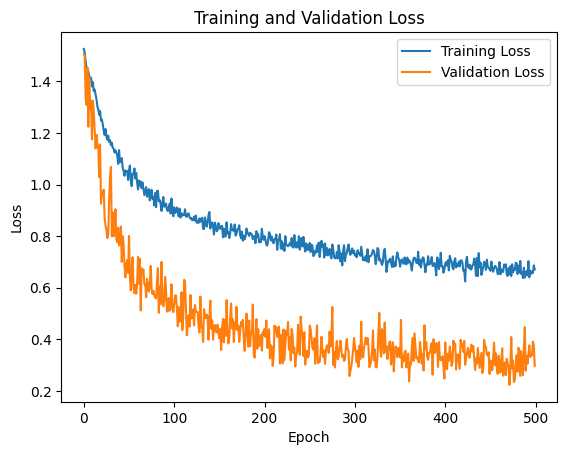

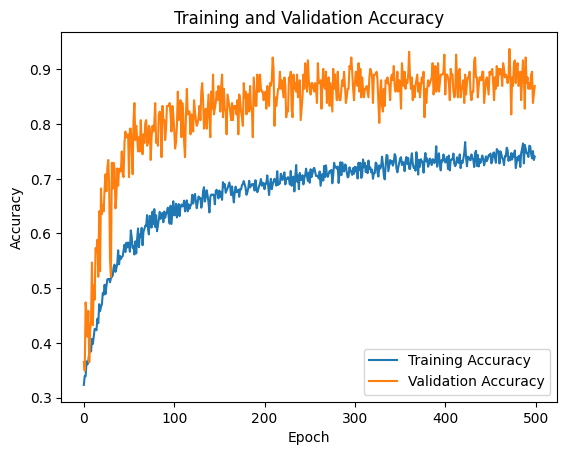

In [58]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Found 60 images belonging to 6 classes.
2/2 [==============================] - 0s 2ms/step


<Figure size 800x800 with 0 Axes>

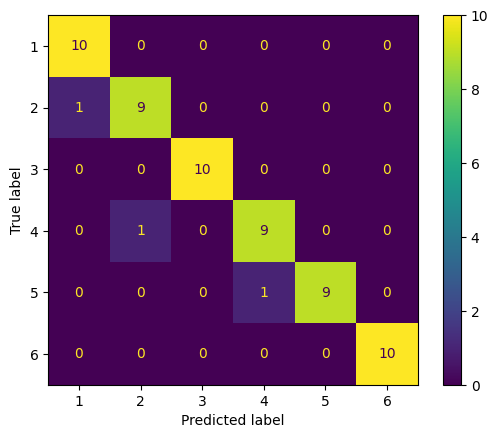

----------------------------
True Class: 2, Predicted Class: 1


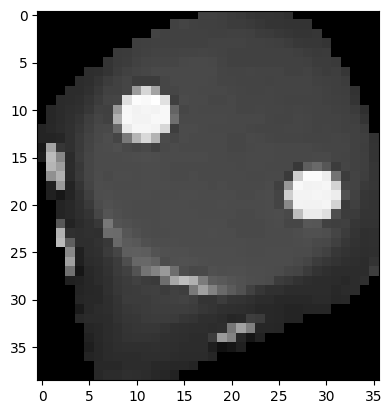

----------------------------
----------------------------
True Class: 4, Predicted Class: 2


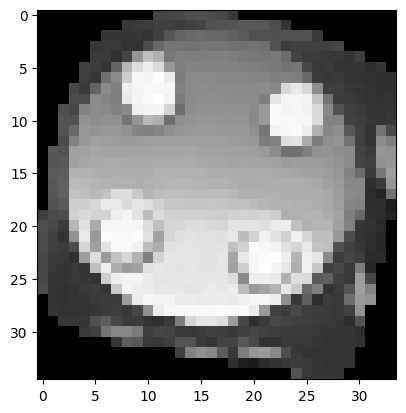

----------------------------
----------------------------
True Class: 5, Predicted Class: 4


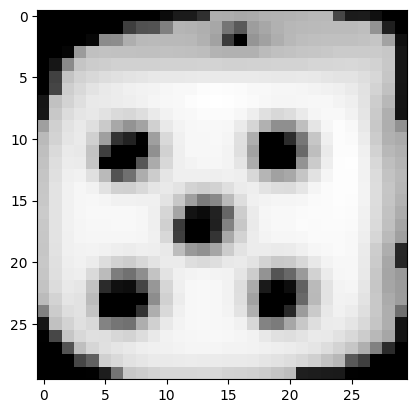

----------------------------


In [59]:

# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/home/bule/projects/Dice/workspace/data/new_filz/Testset',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False  
)

# Predict on the test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_labels = test_generator.classes


conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay(conf_matrix, display_labels=test_generator.class_indices.keys()).plot()
plt.show()


paths = test_generator.filepaths
# for i  in range(len(paths)):
    
#     print('----------------------------')
#     plt.imshow(plt.imread(paths[i]), cmap='gray')
    
#     print(predicted_classes[i]+1)
#     plt.show()
#     print('----------------------------')
    
for i, (true_label, predicted_label, path) in enumerate(zip(true_labels, predicted_classes, paths)):
    if true_label != predicted_label:  # If misclassified
        print('----------------------------')
        plt.imshow(plt.imread(path), cmap='gray')
        print(f"True Class: {true_label + 1}, Predicted Class: {predicted_label + 1}")
        plt.show()
        print('----------------------------')    

Class: 1


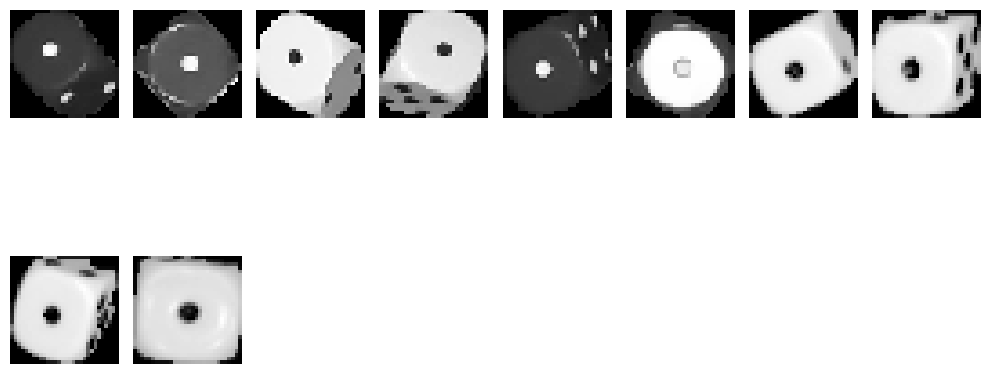

Class: 2


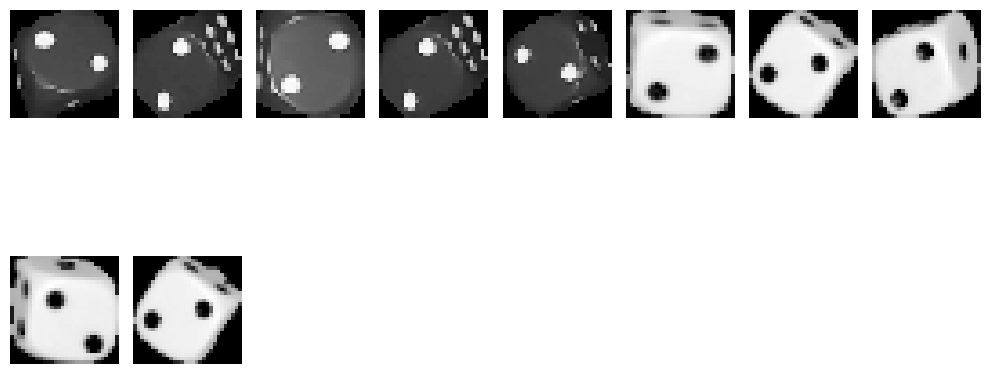

Class: 3


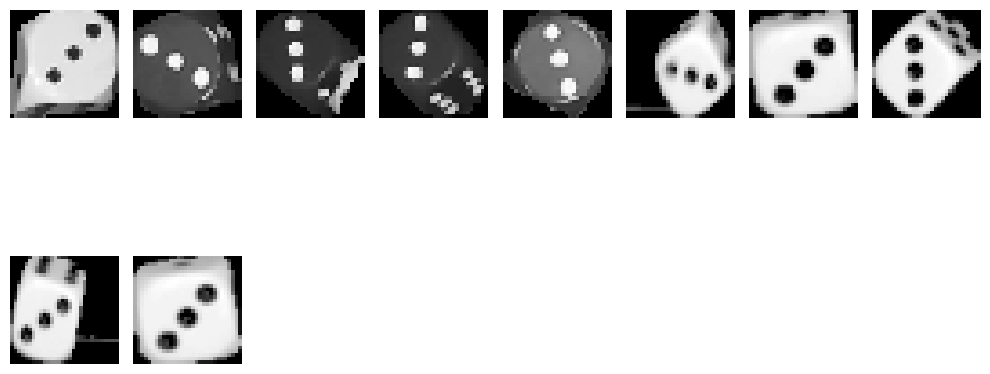

Class: 4


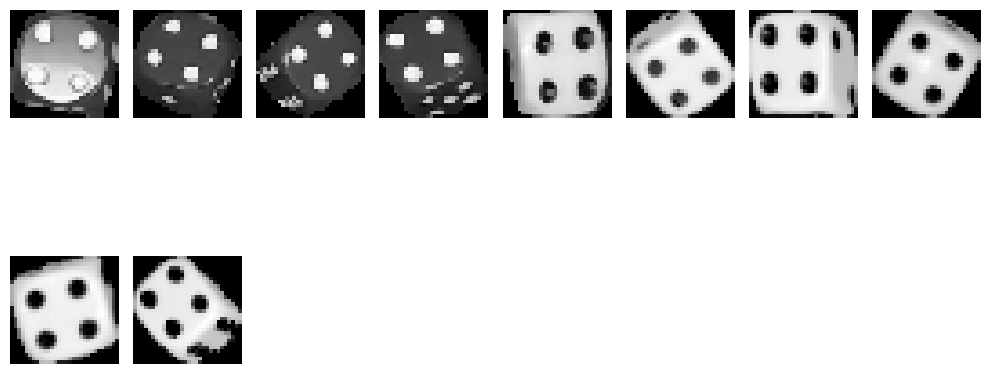

Class: 5


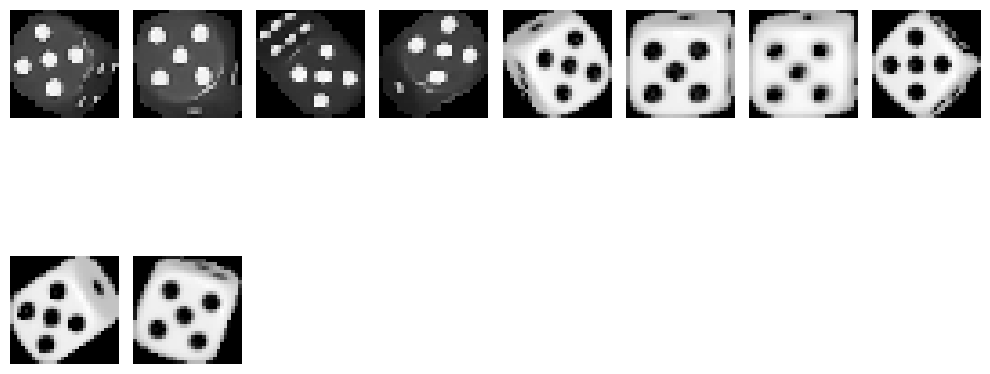

Class: 6


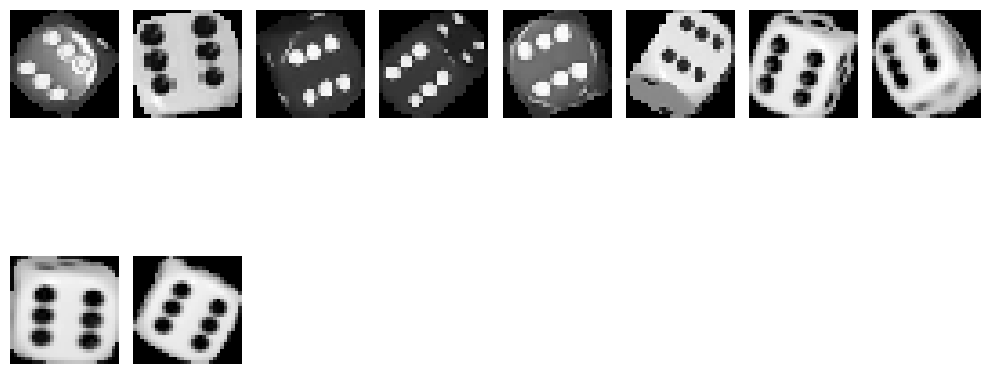

In [60]:

# Get the class labels
class_labels = test_generator.class_indices

# Create a dictionary to store the images for each class
class_images = {class_label: [] for class_label in class_labels}

# Iterate over the test generator and store the images for each class
for i in range(len(test_generator)):
    images, labels = test_generator[i]
    for j in range(len(images)):
        image = images[j]
        label = labels[j]
        class_label = list(class_labels.keys())[list(class_labels.values()).index(np.argmax(label))]
        class_images[class_label].append(image)

# Display the images class by class
for class_label, images in class_images.items():
    print(f"Class: {class_label}")
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(4, 8, i+1)
        plt.imshow(images[i].reshape(img_width, img_height), cmap='gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()


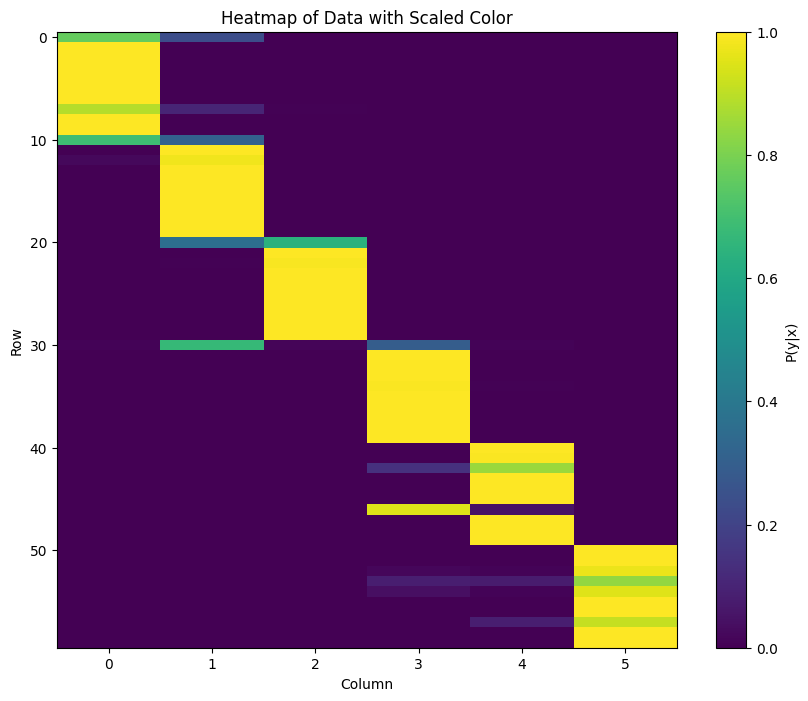

In [61]:
plt.figure(figsize=(10, 8))
plt.imshow(predictions, cmap='viridis', aspect='auto', vmin=0.0, vmax=1.0)
plt.colorbar(label='P(y|x)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Heatmap of Data with Scaled Color')
plt.show()

1/1 [==============================] - 0s 34ms/step


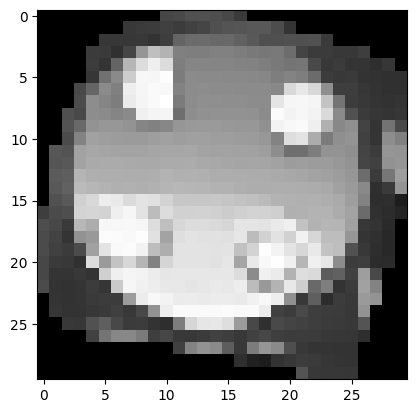

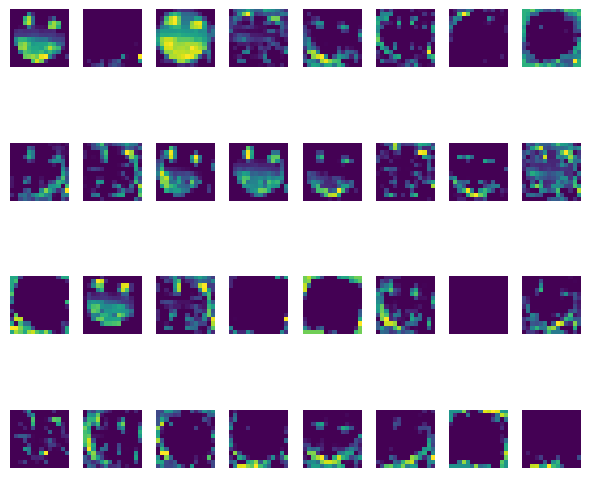

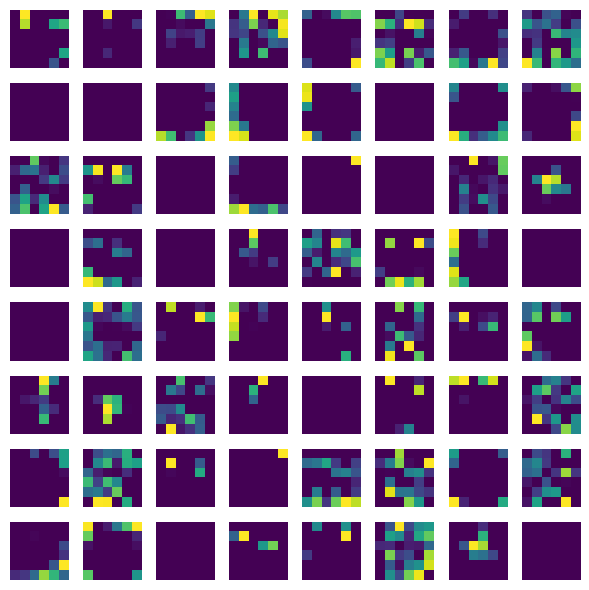

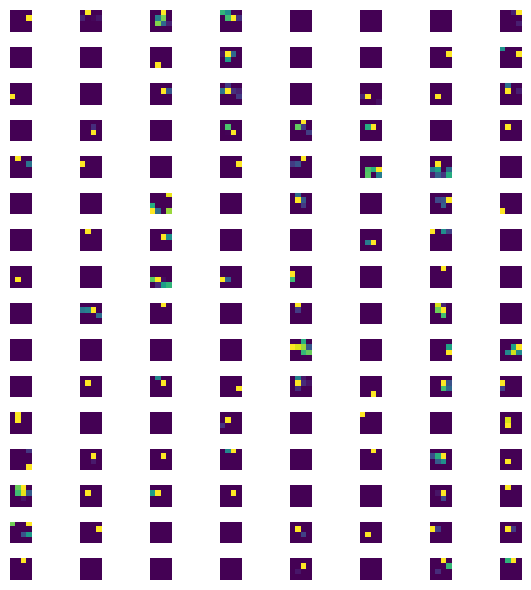

IndexError: tuple index out of range

In [28]:


image_path = '/home/bule/projects/Dice/workspace/data/new_filz/Testset/1/cut_8_2.png'
image_path ='/home/bule/projects/Dice/workspace/data/new_filz/Testset/4/cut_17_2.png'

preprocessed_image = preprocess_image(image_path)

activation_maps = activation_model.predict(preprocessed_image)
activation_maps=[activation_map.squeeze() for activation_map in activation_maps]

plt.imshow(preprocessed_image.squeeze(), cmap='gray')
for map in activation_maps[:-1:2]:
    plot_activation_maps(map)

[ WARN:0@0.203] global loadsave.cpp:248 findDecoder imread_('/home/bule/projects/Dice/data/single_dices/single_dices/dice_classes/1/dice25.png'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

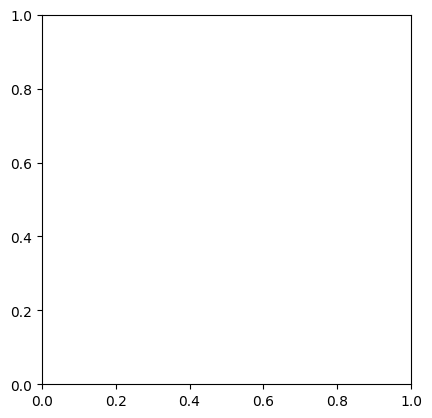

In [24]:
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
import matplotlib.pyplot as plt





def make_prediction(model, file_path):
    # Load the image file, converting it to a numpy array
    img = image.load_img(file_path, target_size=(img_width, img_height), color_mode='grayscale')
    img_array = image.img_to_array(img)

    # Rescale the image (as we did for the training images)
    img_array /= 255.0

    # Add a new axis to make the image array compatible with the model (expects a batch)
    img_array = np.expand_dims(img_array, axis=0)

    # Make the prediction
    prediction = model.predict(img_array)

    return prediction

# Usage
# model should be the trained model you want to use for prediction
# '/path/to/image.png' should be the path to the image you want to predict

img_path = "/home/bule/projects/Dice/data/single_dices/single_dices/dice_classes/1/dice25.png"
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

prediction = make_prediction(model, img_path)
print(prediction)


In [34]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model_single_dices_2304.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite and saved.")


INFO:tensorflow:Assets written to: /tmp/tmpxka3s9ti/assets


INFO:tensorflow:Assets written to: /tmp/tmpxka3s9ti/assets
2024-04-23 21:24:14.921048: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-23 21:24:14.921097: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-23 21:24:14.925200: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxka3s9ti
2024-04-23 21:24:14.928753: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-23 21:24:14.928776: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxka3s9ti
2024-04-23 21:24:14.932220: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-04-23 21:24:14.932797: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-23 21:24:14.960601: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

Model converted to TensorFlow Lite and saved.


## Create Augmented testset

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential

# Assuming you have a root directory where each subdirectory represents a class
root_dir = "/home/bule/projects/Dice/workspace/data/single_dices/testset" 
save_dir = "/home/bule/projects/Dice/workspace/data/single_dices/augmented_testset"


# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define image data generator with rotations
datagen = ImageDataGenerator(rotation_range=360,  fill_mode='constant',cval=0)

# Function to add noise to an image
import numpy as np

def add_noise(img):
    img = img.astype('float32')

    original_shape = img.shape  # Store the original shape
    flattened_img = img.flatten()
    noise = np.random.normal(loc=10.0, scale=1, size=flattened_img.shape)
    noisy_flattened_img = flattened_img + noise

    noisy_img = noisy_flattened_img.reshape(original_shape)

    noisy_img = np.clip(noisy_img, 0, 255)
    
    return noisy_img


# Function to process and save images from a directory
def process_and_save_images_from_directory(class_dir,save_dir):
    for filename in os.listdir(class_dir):
        if filename.endswith(".png"):
            # Load image
            img_path = os.path.join(class_dir, filename)
            save_path = os.path.join(save_dir, filename)
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            # # Apply rotation augmentation and add noise
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=save_dir, save_prefix='aug', save_format='png'):
                # Add noise
                noisy_image = add_noise(batch[0])
                noisy_image = array_to_img(noisy_image)

                # Save the noisy image
                noisy_image.save(os.path.join(save_dir, f'noisy_{i}_{filename}'))
                
                i += 1
                if i >= 2:  # Decide how many augmented images you want per original image
                    break


# Change this to the path of your dataset
for class_name in os.listdir(root_dir):
    print(class_name)
    class_dir = os.path.join(root_dir, class_name)
    target_class_dir = os.path.join(save_dir, class_name)
    if os.path.isdir(class_dir):
        process_and_save_images_from_directory(class_dir,target_class_dir)


2024-02-29 11:14:15.373251: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 11:14:15.374494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 11:14:15.391870: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 11:14:15.391888: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 11:14:15.391900: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

1
5
6
3
4
2
